In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

from tsx.perturbation import TimeSeriesPerturbation
from tsx.xai.lime import LIMETimeSeries, XAIModels
from tsx.xai import evaluation as eva

from data_util import *
from viz import *

import itertools
import pandas as pd
from biokit.viz import corrplot

# Load Data set
- Dataset of Beijin pollution
- Learns pollution for 128 historical steps
- Data is normalized when fitting into the model.

In [ ]:
independents = ["dew", "temp", "press", "wind_direction", "wind_speed", "snow", "rain"]
dependent = "pollution"

# Load data
df = load_data_set_bejin()
x_scaler, y_scaler = get_xy_scalers(df, independents, dependent)

# Normalize data 
df_norm = df.copy()
df_norm[independents] = x_scaler.transform(df[independents].values)
df_norm[dependent] = y_scaler.transform(df[dependent].values.reshape(-1, 1))

# Global param
n_steps = 128
window_size = 8
n_variables = len(independents)
samples_size = 100

## Test set prepare
- We test here for sample size of 1000 instance in test set.
- Test-set include tuples of (X, y)


In [ ]:
# Test set (random)
test_set = []
n_instances = 1000
for i in range(n_instances):
    i_df = get_instance_x(df_norm, n_steps + 1, independents + 
    [dependent])
    _x = i_df.loc[:n_steps-1, independents]
    _y = i_df[dependent]   
    test_set.append((_x.values.T, _y.to_numpy()[-1]))

# Load Explanations and Models from File

The explanations was generated for each options in:
- Scales (Synchronous, Asynchronos )
- Replacement Methods for perturbation (zeros, local_mean, global_mean)
- Models (lstm, wavenet) as (rnn, cnn) based line models

Notice:
- An option is an XAI model, e.g. async-zeros as asynchronous with zeros replacement for perturbation
- An explanation is a averaging over 10 random instances

In [9]:
# Explanations
explanations = np.load('data/explanations.npy', allow_pickle=True)

# Models
wavenet = tf.keras.models.load_model(f"{DATA_DIR}/wavenet_mts_128_1.h5")
lstm = tf.keras.models.load_model(f"{DATA_DIR}/lstm_mts_128_1.h5")

In [96]:
# Functions to perturb test set
def replacements(t, method='zeros'):    
    if method == 'zeros':
        # Calculate zeros replacements
        r = np.zeros_like(t)
    if method == 'mean':
        # Calculate means replacements
        m = t.mean(axis=1)
        r = np.ones_like(t) * m.reshape(t.shape[0], -1)
    
    return r

def mask_percentile(t, percentile=90, axis=1, interpolation='higher', random=False):
    # Create a mask based on 90 percentile of x_coef
    #   > 1 mean on , 0 means off (disabled)
    perc = np.percentile(t, percentile, axis=axis, interpolation=interpolation)

    # This is a mask for x based on 90 percentile of x_coef
    if perc.ndim == 1: 
        perc = perc.reshape(t.shape[0], -1)

    m = 1 - (t >= perc)
    
    # Random and ensure the same number of changed in percentile.
    if random:
        m = m.ravel()
        np.random.shuffle(m)
        m = m.reshape(t.shape)
    return m

def perturb(t, m=None, r=None):
    if m is None:
        m = np.ones_like(t)
    if r is None:
        r = replacements(t, 'zeros')
    # new perturbed x 
    z = t * m + r * (1 - m)
    return z

def perturb_X(X, x_coef, method="zeros", axis=1, percentile=90, random=False):
    """ Perturb X based on coefficient or explanations.
        param x_coef: if it is None, then randome used.
        param axis: 
            - 1 : get percentile rowwise -> get 90 percentile per feature
            - None: consider x_coef as an array -> get 90 percentile overall
    """
    m = mask_percentile(x_coef, percentile, 
                        axis=axis, interpolation="higher", random=random)

    def _f(x):
        r = replacements(x, method=method)
        z = perturb(x, m, r)
        return z

    Z = [_f(x_i) for x_i in X]

    return Z

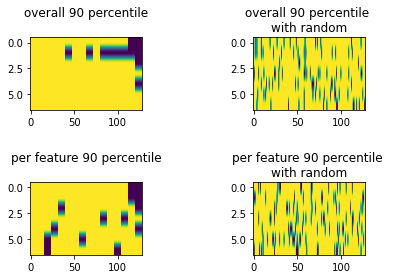

In [97]:
# Compare the difference between overall percentile and percentile per feature w/wo random

# Test:
e = explanations[0]
x_coef = e["xcoef"]
X, y_true = zip(*test_set)
x_arr = X[0]

# Get absolute value for weight, because LIME could be negative -> 90 percentile might not work.
m1 = mask_percentile(np.abs(x_coef), axis=None, interpolation="higher")
m2 = mask_percentile(np.abs(x_coef), axis=None, interpolation="higher", random=True)
m3 = mask_percentile(np.abs(x_coef), axis=1, interpolation="higher")
m4 = mask_percentile(np.abs(x_coef), axis=1, interpolation="higher", random=True)

fig, axes = plt.subplots(2, 2)
ax = axes[0, 0]
ax.imshow(m1, aspect='auto')
ax.set_title("overall 90 percentile\n")
ax = axes[0, 1]
ax.imshow(m2, aspect='auto')
ax.set_title("overall 90 percentile \nwith random")
ax = axes[1, 0]
ax.imshow(m3, aspect='auto')
ax.set_title("per feature 90 percentile\n")
ax = axes[1, 1]
ax.imshow(m4, aspect='auto')
ax.set_title("per feature 90 percentile \nwith random")
plt.subplots_adjust(hspace=1, wspace=1)

# Test perturb_X
#r = replacements(x_arr, method="zeros")
#z = perturb(x_arr, m, r)

#e = explanations[0]
#xcoef = e["xcoef"]
#X_perturbed = perturb_X(X, xcoef, method="zeros")


# Methodology for experiments.

## Root Mean Squared Error in original as base line
1. Fit directy X, y_true, y_pred to f(x) to get the baseline score

## rmse in 90 percentile of explanations
1. For each XAI model we generate a perturbed test set
1. Fit to model and record rmse of perturbed test to the dict
1. Save all scores to the dict {"scale": ..., "model": ...., "method": ...., "xcoef": ....., "rmse": ....}
    - xcoef as explanations.
    - rmse as root mean squared error score (lower better)

## rmse in random perturbed
1. Generate a random perturbed set, notice that:
    - the number of changes =  perturbed test set

## Step 1: RMSE of overall 90 percentile of explanations
## Step 2: RMSE of overall Random
- number of changes in random = overall 90 percentile of explanations (in step 1)

In [114]:
def get_rmse(x, fn, y_true, axis=None, random=False):
    x_test = np.stack([x_i.T for x_i in x])
    y_pred = fn.predict(x_test).ravel()

    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

# Calculate quality measure for each explanation
from sklearn.metrics import mean_squared_error
for e in explanations:
    
    x_coef = e["xcoef"]
    fn = eval(e["model"].replace("_fn", ""))    # remove "_fn" from lstm_fn (custom)

    #1 Create perturbed test set + rmse
    X_p90 = perturb_X(X, x_coef=x_coef, percentile=90, axis=None) # overall case by set axis=None
    rmse = get_rmse(X_p90, fn, y_true)
    e.update({"rmse_p90": rmse})

    #2 Random - same x-coef to get number of changes.
    X_random = perturb_X(X, x_coef=x_coef, percentile=90, axis=None, random=True)
    rmse = get_rmse(X_random, fn, y_true)
    e.update({"rmse_random": rmse})

## Step 3: RMSE of original Test Set X

In [115]:
# Now calculate quality measure for original
#   this not dependent on coef or random, hence get directly from X
# X, y_true = zip(*test_set)
X_test = np.stack([x.T for x in X])
for e in explanations:  
    fn = eval(e["model"].replace("_fn", ""))
    y_pred = fn.predict(X_test).ravel()

    rmse = get_rmse(X_random, fn, y_true)
    e.update({"rmse_random": rmse})

# Evaluation quality for Regression task

Assumptions to be used: 
\begin{equation}
    err(X) < err(X_{random}) < err(X_{p90})
\end{equation}
- with X: Original test set
- $X_{random}$: Randomly perturbed X, based on number of changes in $X_p90$
- $X_{p90}$: Perturbed based on values larger than 90 percentile threshold.

We expect to see:
- $rmse(X) < rmse(X_{random} < rmse(X_{p90})$
- alternative $0 <= diff_{random} < diff(X_{p90})$ in comparison with baseline X

In [117]:
eva_df = pd.DataFrame(list(explanations))
eva_df = eva_df.drop("xcoef", axis=1)
eva_df["rmse_diff_random"] = eva_df.eval("rmse_original - rmse_random")
eva_df["rmse_diff_p90"] = eva_df.eval("rmse_original - rmse_p90")

In [121]:
# Evaluation Result for lstm
tt = eva_df.loc[:, ["scale", "model", "method", "rmse_original","rmse_diff_random", "rmse_diff_p90"]]
eva_lstm = tt.query("model == 'lstm_fn' ")
print("Evaluation Result for lstm - with overall 90 percentile, all used zeros replacement for test set.")
eva_lstm

Evaluation Result for lstm - with overall 90 percentile, all used zeros replacement for test set.


,scale,model,method,rmse_original,rmse_diff_random,rmse_diff_p90
0,async,lstm_fn,zeros,0.14725,0.028208,-0.289072
2,async,lstm_fn,local_mean,0.14725,0.028208,-0.912497
4,async,lstm_fn,global_mean,0.14725,0.028208,-0.298715
6,sync,lstm_fn,zeros,0.14725,0.028208,0.019254
8,sync,lstm_fn,local_mean,0.14725,0.028208,0.054290
10,sync,lstm_fn,global_mean,0.14725,0.028208,-0.001663


## Discussion

The result show the diference in rmse based on the rmse_original. the random have more error than the original then it satisfy the assumption. However the unexpected rmse_diff_p90 is unstable, that does not statisfy the assumption. All async methods turns to better quality with lower rmse after being perturbed. The sync does in the oposite way except for global mean perturbation.

# Per feature 90 percentile 
Previously we use overall 90 percentile -> now we experiment on perturbing values over 90 percentile per feature.
- repeat the whole process above, but uses per feature by set $\textbf{axis=1}$
- the rmse for the original X does not change, we could skip this.


In [127]:
import copy

exp2 = copy.deepcopy(explanations)   # copy the explanations
for e in exp2:
    x_coef = e["xcoef"]
    fn = eval(e["model"].replace("_fn", ""))    # remove "_fn" from lstm_fn (custom)

    #1 Create perturbed test set + rmse
    X_p90 = perturb_X(X, x_coef=x_coef, percentile=90, axis=1) # per feature
    rmse = get_rmse(X_p90, fn, y_true)
    e.update({"rmse_p90": rmse})

    #2 Random - same x-coef to get number of changes.
    X_random = perturb_X(X, x_coef=x_coef, percentile=90, axis=1, random=True)
    rmse = get_rmse(X_random, fn, y_true)
    e.update({"rmse_random": rmse})

In [129]:

eva2_df = pd.DataFrame(list(exp2))
eva2_df = eva2_df.drop("xcoef", axis=1)
eva2_df["rmse_diff_random"] = eva2_df.eval("rmse_original - rmse_random")
eva2_df["rmse_diff_p90"] = eva2_df.eval("rmse_original - rmse_p90")

tt = eva2_df.loc[:, ["scale", "model", "method", "rmse_original","rmse_diff_random", "rmse_diff_p90"]]
eva2_lstm = tt.query("model == 'lstm_fn' ")

print("Evaluation Result for lstm - with per-feature 90 percentile, all used zeros replacement for test set.")
eva2_lstm

Evaluation Result for lstm - with per-feature 90 percentile, all used zeros replacement for test set.


,scale,model,method,rmse_original,rmse_diff_random,rmse_diff_p90
0,async,lstm_fn,zeros,0.14725,0.045759,0.017801
2,async,lstm_fn,local_mean,0.14725,0.034220,-0.021313
4,async,lstm_fn,global_mean,0.14725,-0.002035,0.024027
6,sync,lstm_fn,zeros,0.14725,0.029453,0.019254
8,sync,lstm_fn,local_mean,0.14725,0.032845,0.054290
10,sync,lstm_fn,global_mean,0.14725,0.037247,-0.001663


## Discussion
In this per-feature 90 percentile, the assumption above does not hold for both. However, the score is very close with difference close to zeros.

# Absolute value for coeficiencts

Experiments above was done when coefs is not get absolute. For LIME in regression the weight could be significant negative or positive. In this case, we would like to run it to check if the absolute Weight will hold the assumption
- Again we do not need to calculate rmse for the original X

In [131]:
exp3 = copy.deepcopy(explanations)   # copy the explanations
for e in exp3:
    x_coef = np.abs(e["xcoef"]) # Absolute explanations.
    fn = eval(e["model"].replace("_fn", ""))

    #1 Create perturbed test set + rmse
    X_p90 = perturb_X(X, x_coef=x_coef, percentile=90, axis=None) # Overall
    rmse = get_rmse(X_p90, fn, y_true)
    e.update({"rmse_p90": rmse})

    #2 Random - same x-coef to get number of changes.
    X_random = perturb_X(X, x_coef=x_coef, percentile=90, axis=None, random=True)
    rmse = get_rmse(X_random, fn, y_true)
    e.update({"rmse_random": rmse})

In [132]:

eva3_df = pd.DataFrame(list(exp3))
eva3_df = eva3_df.drop("xcoef", axis=1)
eva3_df["rmse_diff_random"] = eva3_df.eval("rmse_original - rmse_random")
eva3_df["rmse_diff_p90"] = eva3_df.eval("rmse_original - rmse_p90")

tt = eva3_df.loc[:, ["scale", "model", "method", "rmse_original","rmse_diff_random", "rmse_diff_p90"]]
eva3_lstm = tt.query("model == 'lstm_fn' ")

print("Evaluation Result for lstm - absolute weight for overall 90 percentile.")
eva3_lstm

Evaluation Result for lstm - absolute weight for overall 90 percentile.


,scale,model,method,rmse_original,rmse_diff_random,rmse_diff_p90
0,async,lstm_fn,zeros,0.14725,0.059748,0.036485
2,async,lstm_fn,local_mean,0.14725,0.044201,-0.439493
4,async,lstm_fn,global_mean,0.14725,0.042748,-0.294439
6,sync,lstm_fn,zeros,0.14725,0.046190,-0.000264
8,sync,lstm_fn,local_mean,0.14725,0.033906,0.054290
10,sync,lstm_fn,global_mean,0.14725,0.037074,-0.001663


## Conclusion
- The absolute overall 90 percentile for explanations does similarly. The assumption does not hold for percentile 90 (overall), but it holds for random

# Absolute value for coeficiencts per feature (90 percentile)

Continue the exp 3, but with each feature for threshold 90 percentile.

In [134]:
exp4 = copy.deepcopy(explanations)   # copy the explanations
for e in exp4:
    x_coef = np.abs(e["xcoef"]) # Absolute explanations.
    fn = eval(e["model"].replace("_fn", ""))

    #1 Create perturbed test set + rmse
    X_p90 = perturb_X(X, x_coef=x_coef, percentile=90, axis=1) # Per feature
    rmse = get_rmse(X_p90, fn, y_true)
    e.update({"rmse_p90": rmse})

    #2 Random - same x-coef to get number of changes.
    X_random = perturb_X(X, x_coef=x_coef, percentile=90, axis=1, random=True) # Random
    rmse = get_rmse(X_random, fn, y_true)
    e.update({"rmse_random": rmse})

In [135]:

eva4_df = pd.DataFrame(list(exp4))
eva4_df = eva4_df.drop("xcoef", axis=1)
eva4_df["rmse_diff_random"] = eva4_df.eval("rmse_original - rmse_random")
eva4_df["rmse_diff_p90"] = eva4_df.eval("rmse_original - rmse_p90")

tt = eva4_df.loc[:, ["scale", "model", "method", "rmse_original","rmse_diff_random", "rmse_diff_p90"]]
eva4_lstm = tt.query("model == 'lstm_fn' ")

print("Evaluation Result for lstm - absolute weight for overall 90 percentile.")
eva4_lstm

Evaluation Result for lstm - absolute weight for overall 90 percentile.


,scale,model,method,rmse_original,rmse_diff_random,rmse_diff_p90
0,async,lstm_fn,zeros,0.14725,0.035404,-0.002168
2,async,lstm_fn,local_mean,0.14725,0.048594,0.006032
4,async,lstm_fn,global_mean,0.14725,-0.016343,-0.012235
6,sync,lstm_fn,zeros,0.14725,0.058071,-0.000264
8,sync,lstm_fn,local_mean,0.14725,0.041022,0.054290
10,sync,lstm_fn,global_mean,0.14725,0.054007,-0.001663
